In [1]:
import numpy as np 
import pandas as pd 
import pickle
import cv2
import os
from zipfile import ZipFile
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Concatenate, Dense
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.applications import EfficientNetV2B3, NASNetMobile, ResNet152V2, InceptionV3, Xception, DenseNet201
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import seaborn as sns
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries


c:\Users\alsol\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\alsol\miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\alsol\miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
train_Data = pd.read_csv("train.csv")

dataset = []
labels = []

In [3]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [4]:

def prepare_Images(label,path, sigmaX=10):
    img=cv2.imread(path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)

    img_res=cv2.resize(img,(224,224))
    img_res=cv2.addWeighted ( img_res,4, cv2.GaussianBlur( img_res , (0,0) , sigmaX) ,-4 ,128)


    img_array = img_to_array(img_res)

    
    img_array = img_array/255.0
    dataset.append(img_array)
    labels.append(str(label))

In [5]:
id_code_Data = train_Data['id_code']
diagnosis_Data = train_Data['diagnosis']

In [ ]:
for id_code,diagnosis in tqdm(zip(id_code_Data,diagnosis_Data)):
    path = os.path.join('train_images','{}.png'.format(id_code))
    prepare_Images(diagnosis,path)

In [5]:
images = np.array(dataset)
label_arr = np.array(labels)

In [ ]:
np.save("preprocessed_dataset.npy", np.array(dataset))
np.save("preprocessed_labels.npy", np.array(labels))

In [2]:
images = np.load("preprocessed_dataset Improved V1.npy")
label_arr = np.load("preprocessed_labels Improved V1.npy")

In [3]:
x_train,x_test,y_train,y_test = train_test_split(images,label_arr,stratify=label_arr,test_size=0.10)

In [4]:
y_train= np_utils.to_categorical(y_train, num_classes=5)
y_test = np_utils.to_categorical(y_test, num_classes=5)

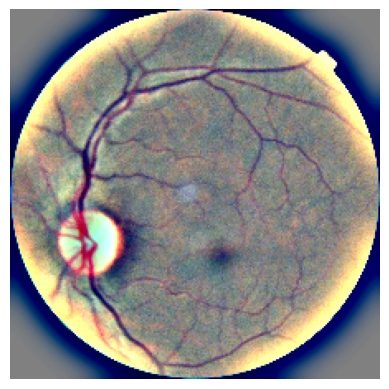

In [8]:
plt.axis('off')
plt.imshow(x_train[31])

In [9]:
x_train.shape

(3295, 224, 224, 3)

In [10]:
x_test.shape

(367, 224, 224, 3)

In [11]:
y_train.shape

(3295,)

In [12]:
y_test.shape

(367,)

In [6]:
reduceLROnPlateau_models = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.0000001, verbose=1, mode='min')
earlyStopping_models = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True, mode='min')

In [5]:
# # Data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )
# datagen.fit(x_train)

In [14]:
# Sequential Model Adding Model Layers

Sequential_model=Sequential()
Sequential_model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(224,224,3)))
Sequential_model.add(MaxPooling2D(pool_size=2))
Sequential_model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
Sequential_model.add(MaxPooling2D(pool_size=2))
Sequential_model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
Sequential_model.add(MaxPooling2D(pool_size=2))
Sequential_model.add(Conv2D(filters=128,kernel_size=2,padding="same",activation="relu"))
Sequential_model.add(MaxPooling2D(pool_size=2))
Sequential_model.add(Dropout(0.2))
Sequential_model.add(Flatten())
Sequential_model.add(Dense(512,activation="relu"))
Sequential_model.add(Dropout(0.2))
Sequential_model.add(Dense(5,activation="softmax"))

In [15]:
# Sequential Model Compiling and Training
Sequential_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
Sequential_model_history = Sequential_model.fit(x_train,y_train,batch_size=32,epochs=20,verbose=1, validation_split=0.1, callbacks=[earlyStopping_models,reduceLROnPlateau_models])

Epoch 1/20
93/93 [==============================] - 4s 32ms/step - loss: 0.9967 - accuracy: 0.6320 - val_loss: 0.9041 - val_accuracy: 0.6879 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 3s 28ms/step - loss: 0.8560 - accuracy: 0.6978 - val_loss: 0.8788 - val_accuracy: 0.6848 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 3s 28ms/step - loss: 0.8067 - accuracy: 0.7083 - val_loss: 0.8248 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 3s 27ms/step - loss: 0.7595 - accuracy: 0.7167 - val_loss: 0.8356 - val_accuracy: 0.7121 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 3s 27ms/step - loss: 0.7268 - accuracy: 0.7302 - val_loss: 0.8069 - val_accuracy: 0.7303 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 3s 27ms/step - loss: 0.6956 - accuracy: 0.7440 - val_loss: 0.7512 - val_accuracy: 0.7303 - lr: 1.0000e-04
Epoch 7/20
93/93 [==============================] - 

In [17]:
Sequential_model.save('CSE438 Final/Sequential Model.h5')

In [18]:
with open('CSE438 Final/Sequential Model.pkl', 'wb') as f:
    pickle.dump(Sequential_model.history, f)

INFO:tensorflow:Assets written to: ram://8b1c530f-a0f8-4530-ab04-6f918290cf70/assets


INFO:tensorflow:Assets written to: ram://8b1c530f-a0f8-4530-ab04-6f918290cf70/assets


In [16]:
# Sequential Model Result
Sequential_pred = Sequential_model.predict(x_test)
Sequential_score = round(accuracy_score(y_test.argmax(axis=1), Sequential_pred.argmax(axis=1)),2)
print(f'Sequential Model Accuracy: {Sequential_score}')
print()
print()
Sequential_report = classification_report(y_test.argmax(axis=1), Sequential_pred.argmax(axis=1))
print(Sequential_report)

12/12 [==============================] - 0s 27ms/step
Sequential Model Accuracy: 0.8


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       181
           1       0.53      0.54      0.53        37
           2       0.69      0.85      0.76       100
           3       0.56      0.26      0.36        19
           4       0.58      0.23      0.33        30

    accuracy                           0.80       367
   macro avg       0.66      0.57      0.59       367
weighted avg       0.79      0.80      0.78       367



In [6]:
# EfficientNetV2B3 + NASNetMobile Initialization

effnet_base_model = EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
effnet_x = effnet_base_model.output
effnet_x = GlobalAveragePooling2D()(effnet_x)

# effnet_x = Dense(1024, activation='relu')(effnet_x)
effnet_x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(effnet_x)
effnet_x = Dropout(0.5)(effnet_x)

effnet_predictions = Dense(5, activation='softmax')(effnet_x)
effnet_model = Model(inputs=effnet_base_model.input, outputs=effnet_predictions)

nasnet_base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
nasnet_x = nasnet_base_model.output
nasnet_x = GlobalAveragePooling2D()(nasnet_x)

# nasnet_x = Dense(1024, activation='relu')(nasnet_x)
nasnet_x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(nasnet_x)
nasnet_x = Dropout(0.5)(nasnet_x)

nasnet_predictions = Dense(5, activation='softmax')(nasnet_x)
nasnet_model = Model(inputs=nasnet_base_model.input, outputs=nasnet_predictions)

In [7]:
# EfficientNetV2B3 + NASNetMobile Compiling

from keras.layers import GlobalAveragePooling2D, Dense, Concatenate, Average

averaged_predictions = Average()([effnet_model.output, nasnet_model.output])
effnet_nasnet_model = Model(inputs=[effnet_model.input, nasnet_model.input], outputs=averaged_predictions)


effnet_nasnet_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\alsol\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
# EfficientNetV2B3 + NASNetMobile Compiling
history = effnet_nasnet_model.fit(
    [x_train, x_train], y_train, batch_size = 4, epochs = 20, verbose = 1, validation_split = 0.1, callbacks=[earlyStopping_models,reduceLROnPlateau_models]
)

# Sequential_model.fit(x_train,y_train,batch_size=32,epochs=20,verbose=1, validation_split=0.1, callbacks=[earlyStopping_models,reduceLROnPlateau_models])

Epoch 1/20
742/742 [==============================] - 191s 181ms/step - loss: 11.4563 - accuracy: 0.6965 - val_loss: 4.8110 - val_accuracy: 0.7212 - lr: 1.0000e-04
Epoch 2/20
742/742 [==============================] - 130s 175ms/step - loss: 2.7601 - accuracy: 0.7599 - val_loss: 1.6580 - val_accuracy: 0.7636 - lr: 1.0000e-04
Epoch 3/20
742/742 [==============================] - 125s 168ms/step - loss: 1.1084 - accuracy: 0.7936 - val_loss: 0.9644 - val_accuracy: 0.7939 - lr: 1.0000e-04
Epoch 4/20
742/742 [==============================] - 128s 173ms/step - loss: 0.7034 - accuracy: 0.8260 - val_loss: 0.7862 - val_accuracy: 0.7939 - lr: 1.0000e-04
Epoch 5/20
742/742 [==============================] - 127s 171ms/step - loss: 0.5454 - accuracy: 0.8465 - val_loss: 0.7555 - val_accuracy: 0.7909 - lr: 1.0000e-04
Epoch 6/20
742/742 [==============================] - 127s 172ms/step - loss: 0.4561 - accuracy: 0.8560 - val_loss: 0.7230 - val_accuracy: 0.8061 - lr: 1.0000e-04
Epoch 7/20
742/742 [=

In [9]:
effnet_nasnet_model.save('CSE438 Final/EfficientNetV2B3 + NasNetMobile Model.h5')

In [11]:
with open('CSE438 Final/EfficientNetV2B3 + NasNetMobile Model.pkl', 'wb') as f:
    pickle.dump(effnet_nasnet_model.history, f)

INFO:tensorflow:Assets written to: ram://9948e638-8654-4102-b2d3-2574f2031720/assets


INFO:tensorflow:Assets written to: ram://9948e638-8654-4102-b2d3-2574f2031720/assets


In [16]:
# EfficientNetV2B3 + NASNetMobile Model Result
effnet_nasnet_pred = effnet_nasnet_model.predict([x_test, x_test])
effnet_nasnet_model_score = round(accuracy_score(y_test.argmax(axis=1), effnet_nasnet_pred.argmax(axis=1)),2)
print(f'EfficientNetV2B3 + NASNetMobile Model Accuracy: {effnet_nasnet_model_score}')
print()
print()
effnet_nasnet_report = classification_report(y_test.argmax(axis=1), effnet_nasnet_pred.argmax(axis=1))
print(effnet_nasnet_report)

12/12 [==============================] - 1s 86ms/step
EfficientNetV2B3 + NASNetMobile Model Accuracy: 0.82


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       181
           1       0.65      0.65      0.65        37
           2       0.74      0.81      0.78       100
           3       0.33      0.37      0.35        19
           4       0.72      0.43      0.54        30

    accuracy                           0.82       367
   macro avg       0.68      0.65      0.66       367
weighted avg       0.82      0.82      0.81       367



In [20]:
# LIME explainer
explainer = LimeImageExplainer()


example_index = 0 
example_image = x_train[example_index]


predicted_probabilities = effnet_nasnet_model.predict([np.array([example_image]),np.array([example_image])])


def model_predict(image_array):
    return effnet_nasnet_model.predict([image_array,image_array])


explanation = explainer.explain_instance(example_image, model_predict, top_labels=1, num_samples=1000)


1/1 [==============================] - 0s 89ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 303ms/step


  1%|          | 10/1000 [00:00<00:37, 26.12it/s]

1/1 [==============================] - 0s 76ms/step


  2%|▏         | 20/1000 [00:00<00:24, 40.38it/s]

1/1 [==============================] - 0s 68ms/step


  3%|▎         | 30/1000 [00:00<00:19, 49.58it/s]

1/1 [==============================] - 0s 75ms/step


  4%|▍         | 40/1000 [00:00<00:17, 55.07it/s]

1/1 [==============================] - 0s 69ms/step


  5%|▌         | 50/1000 [00:00<00:16, 58.13it/s]

1/1 [==============================] - 0s 78ms/step


  6%|▌         | 60/1000 [00:01<00:16, 58.65it/s]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 70/1000 [00:01<00:14, 62.00it/s]

1/1 [==============================] - 0s 62ms/step


  8%|▊         | 80/1000 [00:01<00:14, 65.13it/s]

1/1 [==============================] - 0s 66ms/step


  9%|▉         | 90/1000 [00:01<00:13, 66.55it/s]

1/1 [==============================] - 0s 71ms/step


 10%|█         | 100/1000 [00:01<00:13, 66.98it/s]

1/1 [==============================] - 0s 66ms/step


 11%|█         | 110/1000 [00:01<00:13, 67.58it/s]

1/1 [==============================] - 0s 88ms/step


 12%|█▏        | 120/1000 [00:02<00:13, 65.16it/s]

1/1 [==============================] - 0s 77ms/step


 13%|█▎        | 130/1000 [00:02<00:13, 64.75it/s]

1/1 [==============================] - 0s 78ms/step


 14%|█▍        | 140/1000 [00:02<00:13, 63.25it/s]

1/1 [==============================] - 0s 66ms/step


 15%|█▌        | 150/1000 [00:02<00:13, 64.87it/s]

1/1 [==============================] - 0s 72ms/step


 16%|█▌        | 160/1000 [00:02<00:13, 63.90it/s]

1/1 [==============================] - 0s 60ms/step


 17%|█▋        | 170/1000 [00:02<00:12, 65.65it/s]

1/1 [==============================] - 0s 79ms/step


 18%|█▊        | 180/1000 [00:02<00:12, 65.45it/s]

1/1 [==============================] - 0s 62ms/step


 19%|█▉        | 190/1000 [00:03<00:12, 66.73it/s]

1/1 [==============================] - 0s 73ms/step


 20%|██        | 200/1000 [00:03<00:12, 66.41it/s]

1/1 [==============================] - 0s 71ms/step


 21%|██        | 210/1000 [00:03<00:11, 66.75it/s]

1/1 [==============================] - 0s 67ms/step


 22%|██▏       | 220/1000 [00:03<00:11, 66.87it/s]

1/1 [==============================] - 0s 66ms/step


 23%|██▎       | 230/1000 [00:03<00:11, 66.34it/s]

1/1 [==============================] - 0s 76ms/step


 24%|██▍       | 240/1000 [00:03<00:11, 66.16it/s]

1/1 [==============================] - 0s 77ms/step


 25%|██▌       | 250/1000 [00:04<00:11, 65.81it/s]

1/1 [==============================] - 0s 65ms/step


 26%|██▌       | 260/1000 [00:04<00:11, 64.15it/s]

1/1 [==============================] - 0s 67ms/step


 27%|██▋       | 270/1000 [00:04<00:11, 65.20it/s]

1/1 [==============================] - 0s 70ms/step


 28%|██▊       | 280/1000 [00:04<00:10, 65.89it/s]

1/1 [==============================] - 0s 74ms/step


 29%|██▉       | 290/1000 [00:04<00:10, 64.96it/s]

1/1 [==============================] - 0s 71ms/step


 30%|███       | 300/1000 [00:04<00:10, 65.39it/s]

1/1 [==============================] - 0s 91ms/step


 31%|███       | 310/1000 [00:04<00:11, 62.30it/s]

1/1 [==============================] - 0s 66ms/step


 32%|███▏      | 320/1000 [00:05<00:10, 64.41it/s]

1/1 [==============================] - 0s 79ms/step


 33%|███▎      | 330/1000 [00:05<00:10, 64.47it/s]

1/1 [==============================] - 0s 67ms/step


 34%|███▍      | 340/1000 [00:05<00:10, 65.63it/s]

1/1 [==============================] - 0s 68ms/step


 35%|███▌      | 350/1000 [00:05<00:09, 66.46it/s]

1/1 [==============================] - 0s 67ms/step


 36%|███▌      | 360/1000 [00:05<00:09, 65.73it/s]

1/1 [==============================] - 0s 61ms/step


 37%|███▋      | 370/1000 [00:05<00:09, 63.95it/s]

1/1 [==============================] - 0s 69ms/step


 38%|███▊      | 380/1000 [00:06<00:09, 63.29it/s]

1/1 [==============================] - 0s 78ms/step


 39%|███▉      | 390/1000 [00:06<00:09, 62.99it/s]

1/1 [==============================] - 0s 65ms/step


 40%|████      | 400/1000 [00:06<00:09, 62.74it/s]

1/1 [==============================] - 0s 58ms/step


 41%|████      | 410/1000 [00:06<00:09, 64.54it/s]

1/1 [==============================] - 0s 74ms/step


 42%|████▏     | 420/1000 [00:06<00:09, 63.79it/s]

1/1 [==============================] - 0s 85ms/step


 43%|████▎     | 430/1000 [00:06<00:09, 63.09it/s]

1/1 [==============================] - 0s 88ms/step


 44%|████▍     | 440/1000 [00:06<00:08, 62.64it/s]

1/1 [==============================] - 0s 62ms/step


 45%|████▌     | 450/1000 [00:07<00:08, 63.68it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 460/1000 [00:07<00:08, 64.35it/s]

1/1 [==============================] - 0s 70ms/step


 47%|████▋     | 470/1000 [00:07<00:08, 65.50it/s]

1/1 [==============================] - 0s 77ms/step


 48%|████▊     | 480/1000 [00:07<00:08, 64.95it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 490/1000 [00:07<00:07, 64.49it/s]

1/1 [==============================] - 0s 88ms/step


 50%|█████     | 500/1000 [00:07<00:08, 57.79it/s]

1/1 [==============================] - 0s 79ms/step


 51%|█████     | 510/1000 [00:08<00:08, 59.03it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 520/1000 [00:08<00:07, 62.21it/s]

1/1 [==============================] - 0s 92ms/step


 53%|█████▎    | 530/1000 [00:08<00:07, 60.82it/s]

1/1 [==============================] - 0s 71ms/step


 54%|█████▍    | 540/1000 [00:08<00:07, 62.46it/s]

1/1 [==============================] - 0s 78ms/step


 55%|█████▌    | 550/1000 [00:08<00:07, 63.12it/s]

1/1 [==============================] - 0s 90ms/step


 56%|█████▌    | 560/1000 [00:08<00:07, 61.80it/s]

1/1 [==============================] - 0s 92ms/step


 57%|█████▋    | 570/1000 [00:09<00:07, 60.87it/s]

1/1 [==============================] - 0s 86ms/step


 58%|█████▊    | 580/1000 [00:09<00:07, 59.75it/s]

1/1 [==============================] - 0s 78ms/step


 59%|█████▉    | 590/1000 [00:09<00:06, 61.03it/s]

1/1 [==============================] - 0s 92ms/step


 60%|██████    | 600/1000 [00:09<00:06, 60.24it/s]

1/1 [==============================] - 0s 84ms/step


 61%|██████    | 610/1000 [00:09<00:06, 60.84it/s]

1/1 [==============================] - 0s 65ms/step


 62%|██████▏   | 620/1000 [00:09<00:06, 62.95it/s]

1/1 [==============================] - 0s 73ms/step


 63%|██████▎   | 630/1000 [00:10<00:05, 63.91it/s]

1/1 [==============================] - 0s 79ms/step


 64%|██████▍   | 640/1000 [00:10<00:05, 61.34it/s]

1/1 [==============================] - 0s 77ms/step


 65%|██████▌   | 650/1000 [00:10<00:05, 62.26it/s]

1/1 [==============================] - 0s 76ms/step


 66%|██████▌   | 660/1000 [00:10<00:05, 63.07it/s]

1/1 [==============================] - 0s 83ms/step


 67%|██████▋   | 670/1000 [00:10<00:05, 61.05it/s]

1/1 [==============================] - 0s 83ms/step


 68%|██████▊   | 680/1000 [00:10<00:05, 61.47it/s]

1/1 [==============================] - 0s 89ms/step


 69%|██████▉   | 690/1000 [00:11<00:05, 61.32it/s]

1/1 [==============================] - 0s 66ms/step


 70%|███████   | 700/1000 [00:11<00:04, 63.19it/s]

1/1 [==============================] - 0s 62ms/step


 71%|███████   | 710/1000 [00:11<00:04, 64.13it/s]

1/1 [==============================] - 0s 63ms/step


 72%|███████▏  | 720/1000 [00:11<00:04, 64.00it/s]

1/1 [==============================] - 0s 72ms/step


 73%|███████▎  | 730/1000 [00:11<00:04, 63.51it/s]

1/1 [==============================] - 0s 76ms/step


 74%|███████▍  | 740/1000 [00:11<00:04, 64.11it/s]

1/1 [==============================] - 0s 82ms/step


 75%|███████▌  | 750/1000 [00:11<00:03, 64.11it/s]

1/1 [==============================] - 0s 77ms/step


 76%|███████▌  | 760/1000 [00:12<00:03, 61.39it/s]

1/1 [==============================] - 0s 89ms/step


 77%|███████▋  | 770/1000 [00:12<00:03, 60.98it/s]

1/1 [==============================] - 0s 76ms/step


 78%|███████▊  | 780/1000 [00:12<00:03, 62.00it/s]

1/1 [==============================] - 0s 74ms/step


 79%|███████▉  | 790/1000 [00:12<00:03, 61.13it/s]

1/1 [==============================] - 0s 90ms/step


 80%|████████  | 800/1000 [00:12<00:03, 61.02it/s]

1/1 [==============================] - 0s 77ms/step


 81%|████████  | 810/1000 [00:12<00:03, 61.91it/s]

1/1 [==============================] - 0s 72ms/step


 82%|████████▏ | 820/1000 [00:13<00:02, 62.70it/s]

1/1 [==============================] - 0s 66ms/step


 83%|████████▎ | 830/1000 [00:13<00:02, 63.90it/s]

1/1 [==============================] - 0s 83ms/step


 84%|████████▍ | 840/1000 [00:13<00:02, 62.14it/s]

1/1 [==============================] - 0s 69ms/step


 85%|████████▌ | 850/1000 [00:13<00:02, 62.54it/s]

1/1 [==============================] - 0s 76ms/step


 86%|████████▌ | 860/1000 [00:13<00:02, 63.62it/s]

1/1 [==============================] - 0s 87ms/step


 87%|████████▋ | 870/1000 [00:13<00:02, 62.45it/s]

1/1 [==============================] - 0s 77ms/step


 88%|████████▊ | 880/1000 [00:14<00:01, 62.51it/s]

1/1 [==============================] - 0s 91ms/step


 89%|████████▉ | 890/1000 [00:14<00:01, 60.74it/s]

1/1 [==============================] - 0s 77ms/step


 90%|█████████ | 900/1000 [00:14<00:01, 62.07it/s]

1/1 [==============================] - 0s 82ms/step


 91%|█████████ | 910/1000 [00:14<00:01, 59.32it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 920/1000 [00:14<00:01, 61.74it/s]

1/1 [==============================] - 0s 77ms/step


 93%|█████████▎| 930/1000 [00:14<00:01, 61.26it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 940/1000 [00:15<00:00, 62.08it/s]

1/1 [==============================] - 0s 73ms/step


 95%|█████████▌| 950/1000 [00:15<00:00, 63.03it/s]

1/1 [==============================] - 0s 77ms/step


 96%|█████████▌| 960/1000 [00:15<00:00, 63.70it/s]

1/1 [==============================] - 0s 66ms/step


 97%|█████████▋| 970/1000 [00:15<00:00, 65.45it/s]

1/1 [==============================] - 0s 64ms/step


 98%|█████████▊| 980/1000 [00:15<00:00, 66.67it/s]

1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 990/1000 [00:15<00:00, 67.32it/s]

1/1 [==============================] - 0s 58ms/step


100%|██████████| 1000/1000 [00:15<00:00, 62.81it/s]


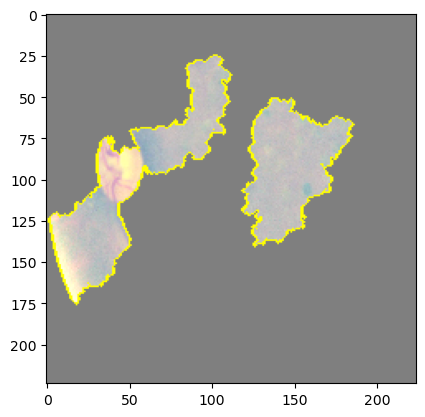

In [21]:

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)


plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

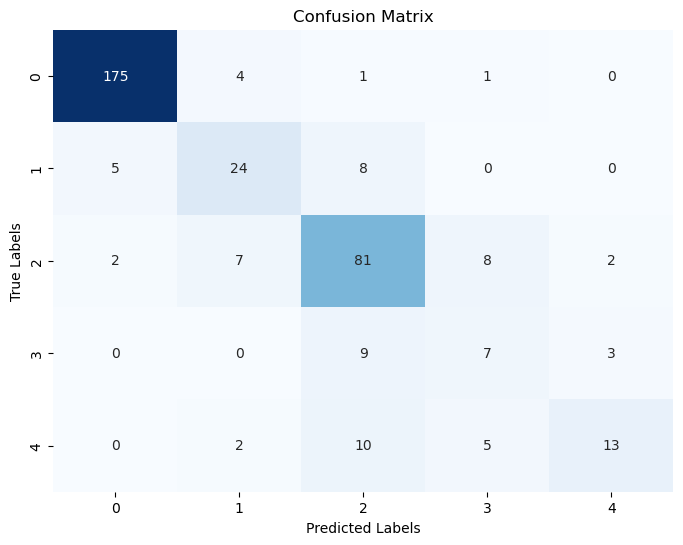

In [27]:
# Confusion Matrix

y_test_true = np.argmax(y_test, axis=1) 
effnet_nasnet_pred_argmax = np.argmax(effnet_nasnet_pred, axis=1)

conf_matrix = confusion_matrix(y_test_true, effnet_nasnet_pred_argmax)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [8]:
# resNet152V2 Initialization

resNet152V2_base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resNet152V2_x = resNet152V2_base_model.output
resNet152V2_x = GlobalAveragePooling2D()(resNet152V2_x)

resNet152V2_x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(resNet152V2_x)
resNet152V2_x = Dropout(0.5)(resNet152V2_x)

resNet152V2_predictions = Dense(5, activation='softmax')(resNet152V2_x)
resNet152V2_model = Model(inputs=resNet152V2_base_model.input, outputs=resNet152V2_predictions)

In [9]:
resNet152V2_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\alsol\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
resNet152V2_model_history = resNet152V2_model.fit(x_train, y_train, batch_size = 4, epochs = 20, verbose = 1, validation_split = 0.1, callbacks=[earlyStopping_models,reduceLROnPlateau_models])

Epoch 1/20
742/742 [==============================] - 96s 98ms/step - loss: 8.2509 - accuracy: 0.7052 - val_loss: 4.5709 - val_accuracy: 0.7576 - lr: 1.0000e-04
Epoch 2/20
742/742 [==============================] - 70s 95ms/step - loss: 3.0373 - accuracy: 0.7666 - val_loss: 1.9976 - val_accuracy: 0.8061 - lr: 1.0000e-04
Epoch 3/20
742/742 [==============================] - 71s 95ms/step - loss: 1.4023 - accuracy: 0.8020 - val_loss: 1.1531 - val_accuracy: 0.7636 - lr: 1.0000e-04
Epoch 4/20
742/742 [==============================] - 71s 96ms/step - loss: 0.8583 - accuracy: 0.8159 - val_loss: 0.7972 - val_accuracy: 0.7848 - lr: 1.0000e-04
Epoch 5/20
742/742 [==============================] - 70s 94ms/step - loss: 0.6270 - accuracy: 0.8405 - val_loss: 0.8516 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 6/20
742/742 [==============================] - ETA: 0s - loss: 0.5012 - accuracy: 0.8597
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
742/742 [==============

In [13]:
resNet152V2_model.save('CSE438 Final/ResNet152V2 Model.h5')

In [14]:
with open('CSE438 Final/ResNet152V2 Model.pkl', 'wb') as f:
    pickle.dump(resNet152V2_model.history, f)

INFO:tensorflow:Assets written to: ram://0e39f61f-f4c2-492a-bcaa-a52f4d86238b/assets


INFO:tensorflow:Assets written to: ram://0e39f61f-f4c2-492a-bcaa-a52f4d86238b/assets


In [15]:
# resNet152V2 Model Result
resNet152V2_pred = resNet152V2_model.predict(x_test)
resNet152V2_score = round(accuracy_score(y_test.argmax(axis=1), resNet152V2_pred.argmax(axis=1)),2)
print(f'ResNet152V2 Model Accuracy: {resNet152V2_score}')
print()
print()
resNet152V2_report = classification_report(y_test.argmax(axis=1), resNet152V2_pred.argmax(axis=1))
print(resNet152V2_report)

12/12 [==============================] - 4s 106ms/step
ResNet152V2 Model Accuracy: 0.81


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       181
           1       0.60      0.57      0.58        37
           2       0.70      0.76      0.73       100
           3       0.29      0.26      0.28        19
           4       0.77      0.57      0.65        30

    accuracy                           0.81       367
   macro avg       0.67      0.63      0.64       367
weighted avg       0.81      0.81      0.81       367



In [6]:
# inceptionV3 Model Initialization

inceptionV3_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inceptionV3_x = inceptionV3_base_model.output
inceptionV3_x = GlobalAveragePooling2D()(inceptionV3_x)

inceptionV3_x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(inceptionV3_x)
inceptionV3_x = Dropout(0.5)(inceptionV3_x)

inceptionV3_predictions = Dense(5, activation='softmax')(inceptionV3_x)
inceptionV3_model = Model(inputs=inceptionV3_base_model.input, outputs=inceptionV3_predictions)

In [8]:
# inceptionV3 Compiling
inceptionV3_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
inceptionV3_model_history = inceptionV3_model.fit(x_train, y_train, batch_size = 4, epochs = 20, verbose = 1, validation_split = 0.1, callbacks=[earlyStopping_models,reduceLROnPlateau_models])

Epoch 1/20
742/742 [==============================] - 53s 56ms/step - loss: 13.9832 - accuracy: 0.6310 - val_loss: 13.0738 - val_accuracy: 0.7455 - lr: 1.0000e-05
Epoch 2/20
742/742 [==============================] - 39s 53ms/step - loss: 12.5427 - accuracy: 0.6931 - val_loss: 11.8295 - val_accuracy: 0.7667 - lr: 1.0000e-05
Epoch 3/20
742/742 [==============================] - 39s 53ms/step - loss: 11.4121 - accuracy: 0.7211 - val_loss: 10.8049 - val_accuracy: 0.7727 - lr: 1.0000e-05
Epoch 4/20
742/742 [==============================] - 39s 53ms/step - loss: 10.3834 - accuracy: 0.7460 - val_loss: 9.9287 - val_accuracy: 0.7606 - lr: 1.0000e-05
Epoch 5/20
742/742 [==============================] - 41s 55ms/step - loss: 9.4912 - accuracy: 0.7616 - val_loss: 9.0991 - val_accuracy: 0.7879 - lr: 1.0000e-05
Epoch 6/20
742/742 [==============================] - 40s 54ms/step - loss: 8.6411 - accuracy: 0.7929 - val_loss: 8.3598 - val_accuracy: 0.7848 - lr: 1.0000e-05
Epoch 7/20
742/742 [=======

In [10]:
inceptionV3_model.save('CSE438 Final/InceptionV3 Model.h5')

In [11]:
with open('CSE438 Final/InceptionV3 Model.pkl', 'wb') as f:
    pickle.dump(inceptionV3_model.history, f)

INFO:tensorflow:Assets written to: ram://73cf3787-4008-4177-89f9-dd5102de8627/assets


INFO:tensorflow:Assets written to: ram://73cf3787-4008-4177-89f9-dd5102de8627/assets


In [11]:
# inceptionV3 Model Result
inceptionV3_pred = inceptionV3_model.predict(x_test)
inceptionV3_score = round(accuracy_score(y_test.argmax(axis=1), inceptionV3_pred.argmax(axis=1)),2)
print(f'inceptionV3 Model Accuracy: {inceptionV3_score}')
print()
print()
inceptionV3_report = classification_report(y_test.argmax(axis=1), inceptionV3_pred.argmax(axis=1))
print(inceptionV3_report)

12/12 [==============================] - 1s 61ms/step
inceptionV3 Model Accuracy: 0.81


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       181
           1       0.61      0.51      0.56        37
           2       0.72      0.81      0.76       100
           3       0.41      0.37      0.39        19
           4       0.62      0.53      0.57        30

    accuracy                           0.81       367
   macro avg       0.66      0.64      0.65       367
weighted avg       0.81      0.81      0.81       367



In [7]:
# xception Model Initialization

xception_base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
xception_x = xception_base_model.output
xception_x = GlobalAveragePooling2D()(xception_x)

xception_x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(xception_x)
xception_x = Dropout(0.5)(xception_x)

xception_predictions = Dense(5, activation='softmax')(xception_x)
xception_model = Model(inputs=xception_base_model.input, outputs=xception_predictions)

In [8]:
# xception Compiling
xception_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\alsol\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
xception_model_history = xception_model.fit(x_train, y_train, batch_size = 4, epochs = 20, verbose = 1, validation_split = 0.1, callbacks=[earlyStopping_models,reduceLROnPlateau_models])

Epoch 1/20
742/742 [==============================] - 41s 44ms/step - loss: 6.3717 - accuracy: 0.6917 - val_loss: 2.2963 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 2/20
742/742 [==============================] - 32s 43ms/step - loss: 1.3661 - accuracy: 0.7639 - val_loss: 0.9443 - val_accuracy: 0.7909 - lr: 1.0000e-04
Epoch 3/20
742/742 [==============================] - 31s 42ms/step - loss: 0.6681 - accuracy: 0.8165 - val_loss: 0.7477 - val_accuracy: 0.7939 - lr: 1.0000e-04
Epoch 4/20
742/742 [==============================] - 32s 43ms/step - loss: 0.4797 - accuracy: 0.8546 - val_loss: 0.6910 - val_accuracy: 0.8061 - lr: 1.0000e-04
Epoch 5/20
742/742 [==============================] - 32s 43ms/step - loss: 0.3421 - accuracy: 0.9059 - val_loss: 0.7877 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 6/20
741/742 [============================>.] - ETA: 0s - loss: 0.2843 - accuracy: 0.9298
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
742/742 [==============

In [10]:
xception_model.save('CSE438 Final/Xception Model.h5')

In [11]:
with open('CSE438 Final/Xception Model.pkl', 'wb') as f:
    pickle.dump(xception_model.history, f)

INFO:tensorflow:Assets written to: ram://f4f3bea0-119e-4cd8-9f35-d118ea271700/assets


INFO:tensorflow:Assets written to: ram://f4f3bea0-119e-4cd8-9f35-d118ea271700/assets


In [12]:
# Xception Model Result
xception_pred = xception_model.predict(x_test)
xception_score = round(accuracy_score(y_test.argmax(axis=1), xception_pred.argmax(axis=1)),2)
print(f'Xception Model Accuracy: {xception_score}')
print()
print()
xception_report = classification_report(y_test.argmax(axis=1), xception_pred.argmax(axis=1))
print(xception_report)

12/12 [==============================] - 1s 55ms/step
inceptionV3 Model Accuracy: 0.81


              precision    recall  f1-score   support

           0       0.94      0.98      0.96       181
           1       0.71      0.46      0.56        37
           2       0.73      0.75      0.74       100
           3       0.35      0.42      0.38        19
           4       0.64      0.60      0.62        30

    accuracy                           0.81       367
   macro avg       0.67      0.64      0.65       367
weighted avg       0.80      0.81      0.80       367



In [9]:
# denseNet201 Model Initialization

denseNet201_base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
denseNet201_x = denseNet201_base_model.output
denseNet201_x = GlobalAveragePooling2D()(denseNet201_x)

denseNet201_x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(denseNet201_x)
denseNet201_x = Dropout(0.5)(denseNet201_x)

denseNet201_predictions = Dense(5, activation='softmax')(denseNet201_x)
denseNet201_model = Model(inputs=denseNet201_base_model.input, outputs=denseNet201_predictions)

In [10]:
# denseNet201 Compiling
denseNet201_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\alsol\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
denseNet201_model_history = denseNet201_model.fit(x_train, y_train, batch_size = 4, epochs = 20, verbose = 1, validation_split = 0.1, callbacks=[earlyStopping_models,reduceLROnPlateau_models])

Epoch 1/20
742/742 [==============================] - 114s 118ms/step - loss: 6.5819 - accuracy: 0.6857 - val_loss: 4.0318 - val_accuracy: 0.7545 - lr: 1.0000e-04
Epoch 2/20
742/742 [==============================] - 84s 113ms/step - loss: 3.2396 - accuracy: 0.7680 - val_loss: 2.6201 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 3/20
742/742 [==============================] - 85s 114ms/step - loss: 2.1526 - accuracy: 0.8057 - val_loss: 1.8197 - val_accuracy: 0.8061 - lr: 1.0000e-04
Epoch 4/20
742/742 [==============================] - 82s 111ms/step - loss: 1.4673 - accuracy: 0.8378 - val_loss: 1.4225 - val_accuracy: 0.7636 - lr: 1.0000e-04
Epoch 5/20
742/742 [==============================] - 83s 112ms/step - loss: 1.0257 - accuracy: 0.8637 - val_loss: 1.2040 - val_accuracy: 0.7970 - lr: 1.0000e-04
Epoch 6/20
742/742 [==============================] - 83s 112ms/step - loss: 0.7527 - accuracy: 0.8870 - val_loss: 1.2071 - val_accuracy: 0.7364 - lr: 1.0000e-04
Epoch 7/20
742/742 [=======

In [12]:
denseNet201_model.save('CSE438 Final/DenseNet201 Model.h5')

In [13]:
with open('CSE438 Final/DenseNet201 Model.pkl', 'wb') as f:
    pickle.dump(denseNet201_model.history, f)

INFO:tensorflow:Assets written to: ram://d46b39cd-5702-4fd8-be36-459a17c43260/assets


INFO:tensorflow:Assets written to: ram://d46b39cd-5702-4fd8-be36-459a17c43260/assets


In [15]:
# inceptionV3 Model Result
denseNet201_pred = denseNet201_model.predict(x_test)
denseNet201_score = round(accuracy_score(y_test.argmax(axis=1), denseNet201_pred.argmax(axis=1)),2)
print(f'DenseNet201 Model Accuracy: {denseNet201_score}')
print()
print()
denseNet201_report = classification_report(y_test.argmax(axis=1), denseNet201_pred.argmax(axis=1))
print(denseNet201_report)

12/12 [==============================] - 1s 114ms/step
DenseNet201 Model Accuracy: 0.84


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       181
           1       0.85      0.59      0.70        37
           2       0.73      0.88      0.80       100
           3       0.39      0.37      0.38        19
           4       0.71      0.50      0.59        30

    accuracy                           0.84       367
   macro avg       0.73      0.67      0.69       367
weighted avg       0.85      0.84      0.84       367



In [8]:
# efficientNetV2B3 Initialization

efficientNetV2B3_base_model = EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efficientNetV2B3_x = efficientNetV2B3_base_model.output
efficientNetV2B3_x = GlobalAveragePooling2D()(efficientNetV2B3_x)

efficientNetV2B3_x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(efficientNetV2B3_x)
efficientNetV2B3_x = Dropout(0.5)(efficientNetV2B3_x)

efficientNetV2B3_predictions = Dense(5, activation='softmax')(efficientNetV2B3_x)
efficientNetV2B3_model = Model(inputs=efficientNetV2B3_base_model.input, outputs=efficientNetV2B3_predictions)

In [9]:
efficientNetV2B3_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\alsol\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
efficientNetV2B3_model_history = efficientNetV2B3_model.fit(x_train, y_train, batch_size = 4, epochs = 20, verbose = 1, validation_split = 0.1, callbacks=[earlyStopping_models,reduceLROnPlateau_models])

Epoch 1/20
742/742 [==============================] - 85s 82ms/step - loss: 7.7165 - accuracy: 0.6820 - val_loss: 3.9676 - val_accuracy: 0.7909 - lr: 1.0000e-04
Epoch 2/20
742/742 [==============================] - 57s 76ms/step - loss: 2.6219 - accuracy: 0.7467 - val_loss: 1.6302 - val_accuracy: 0.7909 - lr: 1.0000e-04
Epoch 3/20
742/742 [==============================] - 58s 79ms/step - loss: 1.2101 - accuracy: 0.7872 - val_loss: 0.9450 - val_accuracy: 0.7848 - lr: 1.0000e-04
Epoch 4/20
742/742 [==============================] - 59s 79ms/step - loss: 0.7356 - accuracy: 0.8233 - val_loss: 0.8438 - val_accuracy: 0.7818 - lr: 1.0000e-04
Epoch 5/20
742/742 [==============================] - 59s 80ms/step - loss: 0.5573 - accuracy: 0.8388 - val_loss: 0.7745 - val_accuracy: 0.7455 - lr: 1.0000e-04
Epoch 6/20
742/742 [==============================] - 57s 77ms/step - loss: 0.4515 - accuracy: 0.8664 - val_loss: 0.6748 - val_accuracy: 0.7939 - lr: 1.0000e-04
Epoch 7/20
742/742 [==============

In [11]:
efficientNetV2B3_model.save('CSE438 Final/EfficientNetV2B3 Model.h5')

In [12]:
with open('CSE438 Final/EfficientNetV2B3 Model.pkl', 'wb') as f:
    pickle.dump(efficientNetV2B3_model.history, f)

INFO:tensorflow:Assets written to: ram://9199a2f4-1e73-4c5b-ba44-ebcf651b4626/assets


INFO:tensorflow:Assets written to: ram://9199a2f4-1e73-4c5b-ba44-ebcf651b4626/assets


In [14]:
# EfficientNetV2B3 Model Result
efficientNetV2B3_pred = efficientNetV2B3_model.predict(x_test)
efficientNetV2B3_score = round(accuracy_score(y_test.argmax(axis=1), efficientNetV2B3_pred.argmax(axis=1)),2)
print(f'EfficientNetV2B3 Model Accuracy: {efficientNetV2B3_score}')
print()
print()
efficientNetV2B3_report = classification_report(y_test.argmax(axis=1), efficientNetV2B3_pred.argmax(axis=1))
print(efficientNetV2B3_report)

12/12 [==============================] - 1s 76ms/step
EfficientNetV2B3 Model Accuracy: 0.76


              precision    recall  f1-score   support

           0       0.94      0.98      0.96       181
           1       0.64      0.43      0.52        37
           2       0.62      0.71      0.66       100
           3       0.18      0.16      0.17        19
           4       0.48      0.37      0.42        30

    accuracy                           0.76       367
   macro avg       0.57      0.53      0.54       367
weighted avg       0.75      0.76      0.75       367



In [7]:
# NasNetMobile Model Initialization

nasNetMobile_base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
nasNetMobile_x = nasNetMobile_base_model.output
nasNetMobile_x = GlobalAveragePooling2D()(nasNetMobile_x)

nasNetMobile_x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(nasNetMobile_x)
nasNetMobile_x = Dropout(0.5)(nasNetMobile_x)

nasNetMobile_predictions = Dense(5, activation='softmax')(nasNetMobile_x)
nasNetMobile_model = Model(inputs=nasNetMobile_base_model.input, outputs=nasNetMobile_predictions)

In [8]:
# NasNetMobile Compiling
nasNetMobile_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\alsol\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
nasNetMobile_model_history = nasNetMobile_model.fit(x_train, y_train, batch_size = 4, epochs = 20, verbose = 1, validation_split = 0.1, callbacks=[earlyStopping_models,reduceLROnPlateau_models])

Epoch 1/20
742/742 [==============================] - 114s 110ms/step - loss: 7.9609 - accuracy: 0.7032 - val_loss: 6.0349 - val_accuracy: 0.6061 - lr: 1.0000e-04
Epoch 2/20
742/742 [==============================] - 77s 104ms/step - loss: 3.9343 - accuracy: 0.7764 - val_loss: 3.1573 - val_accuracy: 0.7030 - lr: 1.0000e-04
Epoch 3/20
742/742 [==============================] - 78s 105ms/step - loss: 2.0721 - accuracy: 0.8094 - val_loss: 2.4117 - val_accuracy: 0.6303 - lr: 1.0000e-04
Epoch 4/20
742/742 [==============================] - 76s 102ms/step - loss: 1.1597 - accuracy: 0.8418 - val_loss: 1.2239 - val_accuracy: 0.7909 - lr: 1.0000e-04
Epoch 5/20
742/742 [==============================] - 74s 100ms/step - loss: 0.7361 - accuracy: 0.8718 - val_loss: 1.1681 - val_accuracy: 0.7879 - lr: 1.0000e-04
Epoch 6/20
742/742 [==============================] - 75s 101ms/step - loss: 0.5153 - accuracy: 0.8904 - val_loss: 1.0782 - val_accuracy: 0.7727 - lr: 1.0000e-04
Epoch 7/20
742/742 [=======

In [10]:
nasNetMobile_model.save('CSE438 Final/NasNetMobile Model.h5')

In [11]:
# NasNetMobile Model Result
nasNetMobile_pred = nasNetMobile_model.predict(x_test)
nasNetMobile_score = round(accuracy_score(y_test.argmax(axis=1), nasNetMobile_pred.argmax(axis=1)),2)
print(f'nasNetMobile Model Accuracy: {nasNetMobile_score}')
print()
print()
nasNetMobile_report = classification_report(y_test.argmax(axis=1), nasNetMobile_pred.argmax(axis=1))
print(nasNetMobile_report)

12/12 [==============================] - 4s 41ms/step
nasNetMobile Model Accuracy: 0.8


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       181
           1       0.48      0.70      0.57        37
           2       0.74      0.73      0.74       100
           3       0.00      0.00      0.00        19
           4       0.57      0.53      0.55        30

    accuracy                           0.80       367
   macro avg       0.55      0.59      0.57       367
weighted avg       0.77      0.80      0.78       367

